In [50]:
!pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/b8/9d/1ce80cee7c5ef60f2fcc7e9fa97f29f7a8de3dc5a08922b3b2f1e9106481/lightgbm-4.1.0-py3-none-manylinux_2_28_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 3.2 MB/s eta 0:00:0000:0100:010m


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
# from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler


#Метрики
from sklearn.metrics import mean_absolute_error, mean_squared_error


from sklearn.dummy import DummyRegressor
#from imblearn.pipeline import make_pipeline
from sklearn.pipeline import make_pipeline
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [72]:
#Изменим настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', str)
warnings.simplefilter("ignore")
pd.options.mode.chained_assignment = None

SEED = 692281488

## Анализ датасета

In [73]:
df_train_orig = pd.read_csv('data/train_dataset.csv',  parse_dates=[0])
df_test_orig = pd.read_csv('data/test_dataset.csv',  parse_dates=[0])

In [74]:
#Функция для возврата часа в дату
def date_plus_hours_to_index(data):
    data = data.copy()
    data['date'] = data['date'] + pd.to_timedelta(data['time'] , 'H')
    data = data.set_index('date')
    return data

In [75]:
df_train = date_plus_hours_to_index(df_train_orig)
df_test = date_plus_hours_to_index(df_test_orig)

In [76]:
# print(f'Значения индекса монотонны: {df_train_orig.index.is_monotonic}')
df_train

,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2019-01-01 00:00:00,0,481.51,2.9,2.0,"пасм, ветер",ветер
2019-01-01 01:00:00,1,462.872,2.9,2.0,"пасм, ветер",ветер
2019-01-01 02:00:00,2,449.718,2.9,2.0,"пасм, ветер",ветер
2019-01-01 03:00:00,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01 04:00:00,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"
...,...,...,...,...,...,...
2023-03-31 19:00:00,19,552.96,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31 20:00:00,20,563.985,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31 21:00:00,21,560.191,6.3,5.0,"пасм, 61%","пасм, дымка"


In [77]:
# print(f'Значения индекса монотонны: {df_test_orig.index.is_monotonic}')
df_test

,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2023-04-01 00:00:00,0,479.282,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 01:00:00,1,445.182,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 02:00:00,2,424.225,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 03:00:00,3,413.866,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
2023-04-01 04:00:00,4,408.146,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
...,...,...,...,...,...,...
2023-07-31 19:00:00,19,453.173,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31 20:00:00,20,446.287,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31 21:00:00,21,444.373,15.8,17.0,"пасм, 24% дождь",п/обл


### Первичный анализ

In [78]:
#список признаков, по которым функция анализа не будет строить гистограммы
exception_list = ['weather_pred', 'weather_fact', 'time']

##### [Funct] Функция для первичного анализа

In [80]:
def data_analyse(data, exception_list = []):
    list_c = data.columns.unique()
    temp = data.copy()
    print(temp.info())
    print('-'* 25)
    if temp.duplicated().sum() == 0:
        print(f'Явных дубликатов нет')
    else:
        print(f'Количество явных дубликатов в датасете:{temp.duplicated().sum()}')
    for col_l in list_c:
        uniq_count = temp[col_l].nunique()
        print('-'* 25)
        print(f'{col_l}')
        print('Уникальные значения')
        print(f'Первые 5 значений: {temp[col_l].sort_values().head(5).unique()}')
        print(f'Последние 5 значений: {temp[col_l].sort_values(ascending = False).head(5).unique()}')
        print(f'Количество уникальных значений: {uniq_count},        процент уникальных значений: {round(uniq_count/len(temp)*100, 2)}%')
        print(f'Количество нулевых значений: {temp[(temp[col_l] == 0) | (temp[col_l] == 0.0)][col_l].count()},        процент нулевых значений: {round(temp[temp[col_l] == 0][col_l].count()/len(temp)*100, 2)}%')
        print(f'Количество пропущенных значений: {temp[col_l].isna().sum()},        процент пропущенных значений:{round(temp[col_l].isna().sum()/len(temp)*100, 2)}%')
        if col_l not in exception_list:
            data[col_l].hist(bins = 100)
            plt.title(col_l)
            plt.show()
    try:
        plt.figure(figsize=(8,8), dpi= 80)
        sns.heatmap(data.corr(),  cmap='Purples', center=0, annot=True)
        plt.title('Зависимость признаков')
        plt.show()
    except:
        print('Коррелирующих признаков нет')
    display(data)
    display(data.describe().round(3))  

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37224 entries, 2019-01-01 00:00:00 to 2023-03-31 23:00:00
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          37224 non-null  int64  
 1   target        37224 non-null  float64
 2   temp          37224 non-null  float64
 3   temp_pred     37136 non-null  float64
 4   weather_pred  37136 non-null  object 
 5   weather_fact  37223 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 2.0+ MB
None
-------------------------
Явных дубликатов нет
-------------------------
time
Уникальные значения
Первые 5 значений: [0]
Последние 5 значений: [23]
Количество уникальных значений: 24,        процент уникальных значений: 0.06%
Количество нулевых значений: 1551,        процент нулевых значений: 4.17%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%
-------------------------
target
Уникальные значения
Первые 5 значени

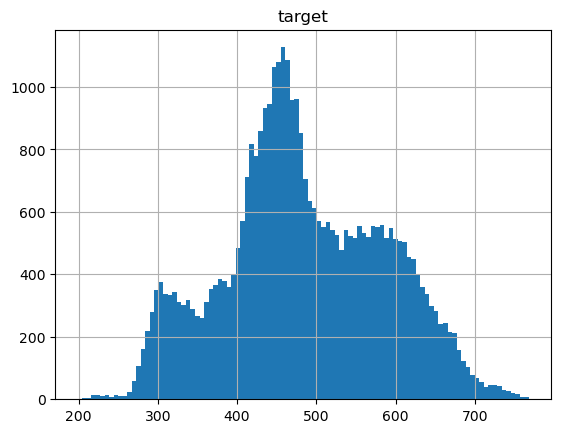

-------------------------
temp
Уникальные значения
Первые 5 значений: [-21.7 -20.9]
Последние 5 значений: [32.5 32.2]
Количество уникальных значений: 474,        процент уникальных значений: 1.27%
Количество нулевых значений: 171,        процент нулевых значений: 0.46%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%


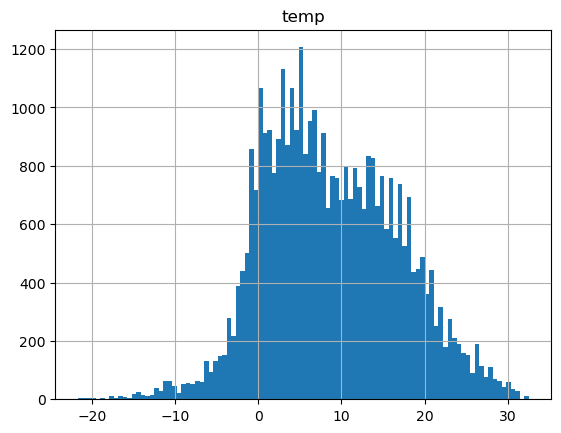

-------------------------
temp_pred
Уникальные значения
Первые 5 значений: [-20. -19.]
Последние 5 значений: [33. 32.]
Количество уникальных значений: 54,        процент уникальных значений: 0.15%
Количество нулевых значений: 1506,        процент нулевых значений: 4.05%
Количество пропущенных значений: 88,        процент пропущенных значений:0.24%


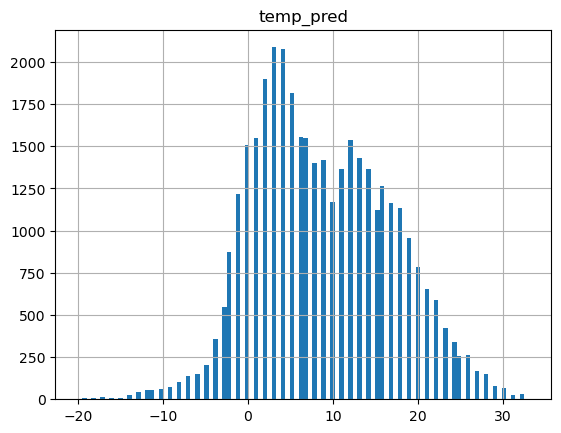

-------------------------
weather_pred
Уникальные значения
Первые 5 значений: [' п/обл, 35% дождь']
Последние 5 значений: ['ясно,ветер']
Количество уникальных значений: 2181,        процент уникальных значений: 5.86%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 88,        процент пропущенных значений:0.24%
-------------------------
weather_fact
Уникальные значения
Первые 5 значений: [' обл, ветер']
Последние 5 значений: ['ясно,ветерок']
Количество уникальных значений: 580,        процент уникальных значений: 1.56%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 1,        процент пропущенных значений:0.0%
Коррелирующих признаков нет


,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2019-01-01 00:00:00,0,481.51,2.9,2.0,"пасм, ветер",ветер
2019-01-01 01:00:00,1,462.872,2.9,2.0,"пасм, ветер",ветер
2019-01-01 02:00:00,2,449.718,2.9,2.0,"пасм, ветер",ветер
2019-01-01 03:00:00,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01 04:00:00,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"
...,...,...,...,...,...,...
2023-03-31 19:00:00,19,552.96,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31 20:00:00,20,563.985,7.9,6.0,"пасм, 61%","пасм, дымка"
2023-03-31 21:00:00,21,560.191,6.3,5.0,"пасм, 61%","пасм, дымка"


,time,target,temp,temp_pred
count,37224.0,37224.0,37224.0,37136.0
mean,11.5,483.731,8.749,8.769
std,6.922,101.459,8.126,8.018
min,0.0,198.982,-21.7,-20.0
25%,5.75,418.951,2.6,3.0
50%,11.5,473.064,7.9,8.0
75%,17.25,561.217,14.7,15.0
max,23.0,767.888,32.5,33.0


<Figure size 640x640 with 0 Axes>

In [81]:
data_analyse(df_train, exception_list)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2928 entries, 2023-04-01 00:00:00 to 2023-07-31 23:00:00
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          2928 non-null   int64  
 1   target        2928 non-null   float64
 2   temp          2928 non-null   float64
 3   temp_pred     2904 non-null   float64
 4   weather_pred  2904 non-null   object 
 5   weather_fact  2928 non-null   object 
dtypes: float64(3), int64(1), object(2)
memory usage: 160.1+ KB
None
-------------------------
Явных дубликатов нет
-------------------------
time
Уникальные значения
Первые 5 значений: [0]
Последние 5 значений: [23]
Количество уникальных значений: 24,        процент уникальных значений: 0.82%
Количество нулевых значений: 122,        процент нулевых значений: 4.17%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%
-------------------------
target
Уникальные значения
Первые 5 значени

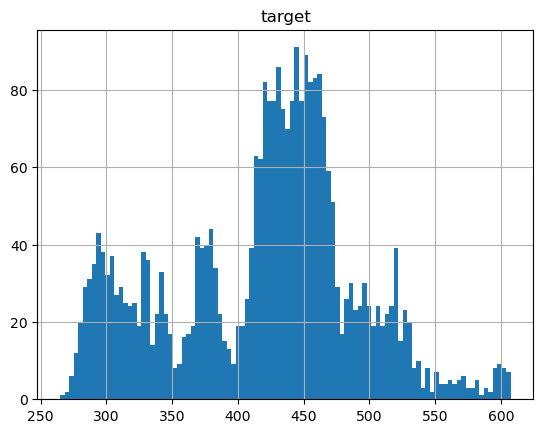

-------------------------
temp
Уникальные значения
Первые 5 значений: [-3.1 -2.9]
Последние 5 значений: [31.7 30.6]
Количество уникальных значений: 270,        процент уникальных значений: 9.22%
Количество нулевых значений: 3,        процент нулевых значений: 0.1%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%


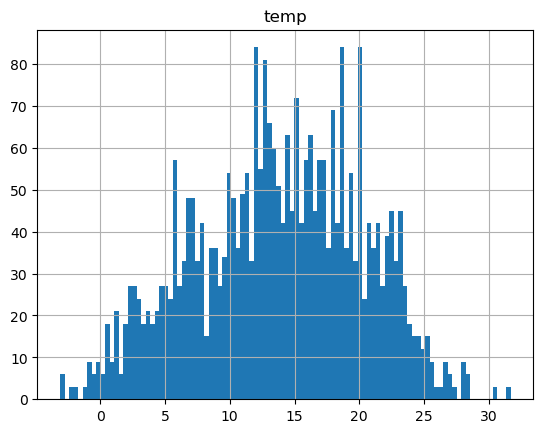

-------------------------
temp_pred
Уникальные значения
Первые 5 значений: [-3.]
Последние 5 значений: [29.]
Количество уникальных значений: 32,        процент уникальных значений: 1.09%
Количество нулевых значений: 54,        процент нулевых значений: 1.84%
Количество пропущенных значений: 24,        процент пропущенных значений:0.82%


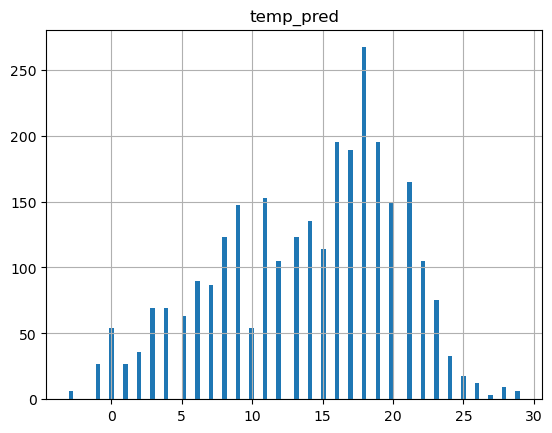

-------------------------
weather_pred
Уникальные значения
Первые 5 значений: ['0']
Последние 5 значений: ['ясно, юго-зап.ветер' 'ясно, штиль']
Количество уникальных значений: 246,        процент уникальных значений: 8.4%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 24,        процент пропущенных значений:0.82%
-------------------------
weather_fact
Уникальные значения
Первые 5 значений: ['дождь']
Последние 5 значений: ['ясно, хол.ветерок']
Количество уникальных значений: 121,        процент уникальных значений: 4.13%
Количество нулевых значений: 0,        процент нулевых значений: 0.0%
Количество пропущенных значений: 0,        процент пропущенных значений:0.0%
Коррелирующих признаков нет


,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2023-04-01 00:00:00,0,479.282,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 01:00:00,1,445.182,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 02:00:00,2,424.225,5.7,5.0,"пасм, 58%","пасм, морось"
2023-04-01 03:00:00,3,413.866,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
2023-04-01 04:00:00,4,408.146,5.0,4.0,"пасм, 71% дождь","пасм, дымка"
...,...,...,...,...,...,...
2023-07-31 19:00:00,19,453.173,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31 20:00:00,20,446.287,17.2,18.0,"пасм, 24% дождь",п/обл
2023-07-31 21:00:00,21,444.373,15.8,17.0,"пасм, 24% дождь",п/обл


,time,target,temp,temp_pred
count,2928.0,2928.0,2928.0,2904.0
mean,11.5,419.467,13.769,13.91
std,6.923,71.393,6.48,6.382
min,0.0,264.819,-3.1,-3.0
25%,5.75,371.384,9.2,9.0
50%,11.5,431.477,14.0,15.0
75%,17.25,462.414,18.7,19.0
max,23.0,607.474,31.7,29.0


<Figure size 640x640 with 0 Axes>

In [82]:
data_analyse(df_test, exception_list)

In [83]:
#Посмотрим на динамику среднего значения и среднеквадратичного отклонения в разрезе 30 и 160 дней
def data_std_mean(data, count_rollin):
    data_copy = data.copy()
    data_copy.sort_index(inplace=True)
    data_copy = data_copy.resample('1D').sum() 
    data_copy['mean'] = data_copy['target'].rolling(count_rollin).mean()
    data_copy['std'] = data_copy['target'].rolling(count_rollin).std()
    
    plt.figure(figsize=(20, 6))
    plt.subplot(312)
    data_copy[['target', 'mean', 'std']].plot(ax=plt.gca())
    plt.show()

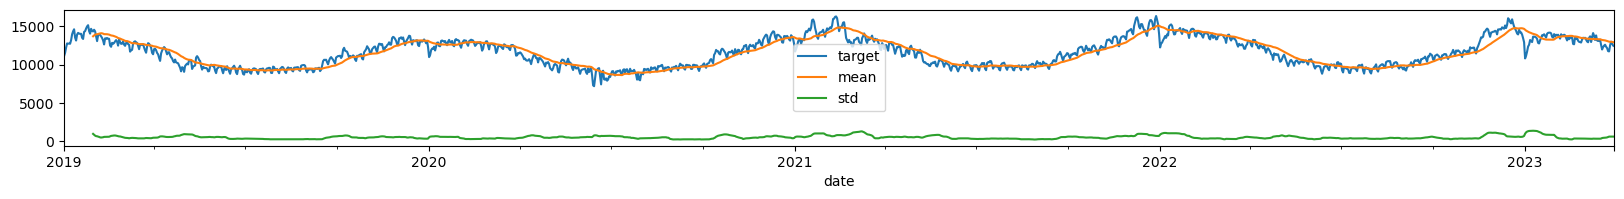

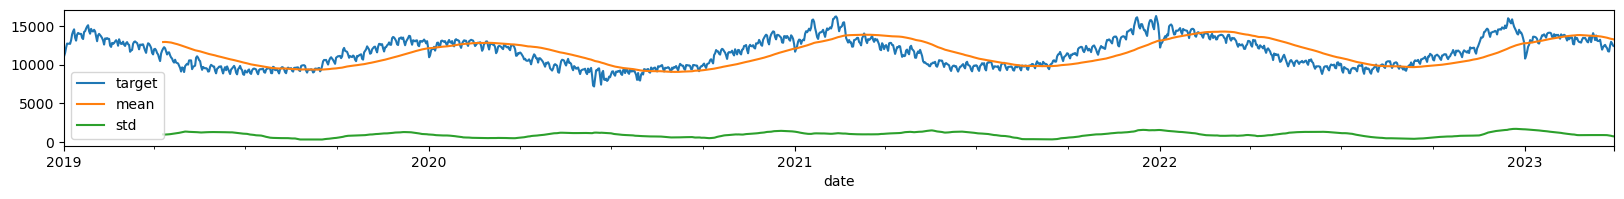

In [84]:
data_std_mean(df_train, 30)
data_std_mean(df_train, 100)

#### Тест Дики-Фуллера на стационарность

In [85]:
ts = df_train['target']
st_test = adfuller(ts, regression = 'ctt')
print('ADF Statistic: %f' % st_test[0])
print('p-value: %f' % st_test[1])
print('Critical Values:')
for key, value in st_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.572233
p-value: 0.005070
Critical Values:
	1%: -4.371
	5%: -3.833
	10%: -3.553


Исходя из полученных результатов, мы можем сделать вывод, что данные являются стационарными. Это означает, что они не имеют тренда или сезонности, и статистические характеристики данных могут быть считаны как постоянные с течением времени. p.s. Но это просто для полноты картины

<b>Сезонность и Тренд

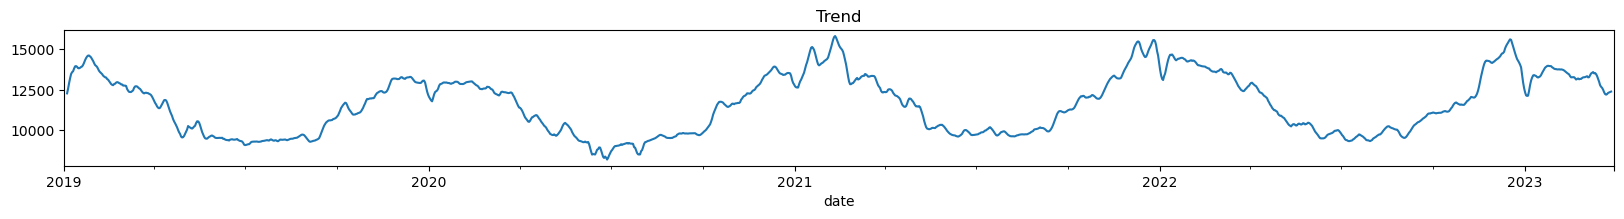

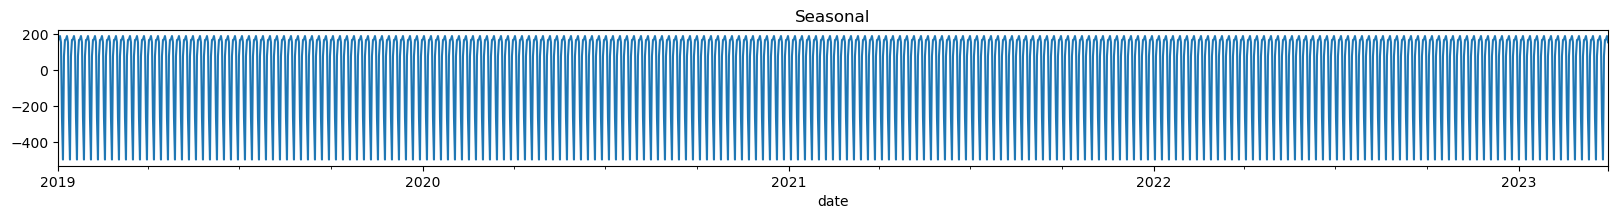

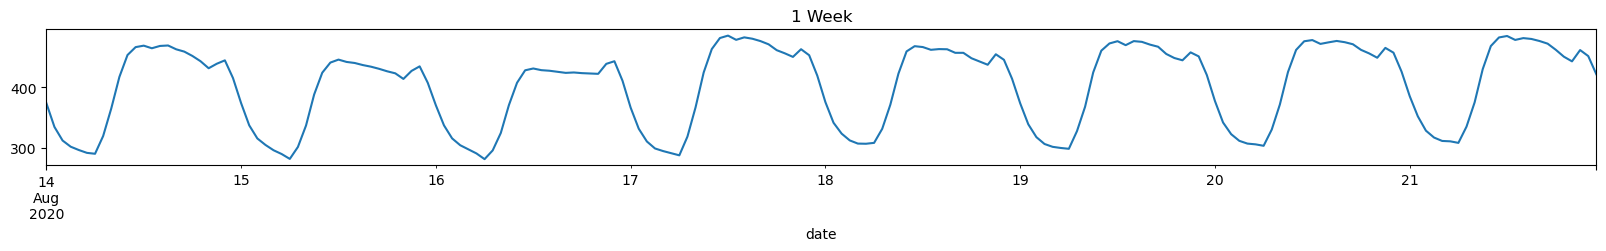

In [86]:
df = df_train['target'].resample('1D').sum() 
decomposed = seasonal_decompose(df) 
# Тренд
plt.figure(figsize=(20, 6))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.show()
#Сезонность
plt.figure(figsize=(20, 6))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.show()
#1 Неделя
plt.figure(figsize=(20, 6))
plt.subplot(313)
df_train.loc['2020-08-14':'2020-08-21', 'target'].plot(ax=plt.gca())
plt.title('1 Week')
plt.show()

In [87]:
df_train.head()

,time,target,temp,temp_pred,weather_pred,weather_fact
date,,,,,,
2019-01-01 00:00:00,0,481.51,2.9,2.0,"пасм, ветер",ветер
2019-01-01 01:00:00,1,462.872,2.9,2.0,"пасм, ветер",ветер
2019-01-01 02:00:00,2,449.718,2.9,2.0,"пасм, ветер",ветер
2019-01-01 03:00:00,3,430.908,4.3,2.0,"пасм, ветер","ветер, пасм"
2019-01-01 04:00:00,4,415.163,4.3,2.0,"пасм, ветер","ветер, пасм"


In [102]:
# Функция дополнения датасета временными лагами и скользящими средними (сутки, неделя, месяц)
def make_features(df, max_lag=672, rolling_mean_size=[24, 168, 672], target='target'):
    new_df = df.copy()
#     data['year'] = data.index.year
    new_df['month'] = new_df.index.month
    new_df['day'] = new_df.index.day
    new_df['dayofweek'] = new_df.index.dayofweek
    
    for lag in range(1+24, max_lag + 1+24):
        new_df['lag_{}'.format(lag)] = new_df[target].shift(lag)

    for size in rolling_mean_size:
        new_df['roll_mean_{}'.format(size)] = new_df[target].shift(24).rolling(size).mean()
  
#    new_df = new_df.dropna()
    
    return new_df

In [103]:
# Функция сдвига фактических данных температуры и погоды на одни сутки
def shift_features_fact(df, list_fact_columns=['temp', 'weather_fact']):
    new_df = df.copy()
    for column in list_fact_columns:
        new_df[column] = new_df[column].shift(24)
    
    return new_df

In [90]:
df_train = make_features(df_train)
df_train = shift_features_fact(df_train)
df_train = df_train.dropna()

In [91]:
df_train.head()

,time,target,temp,temp_pred,weather_pred,weather_fact,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,lag_61,lag_62,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,lag_73,lag_74,lag_75,lag_76,lag_77,lag_78,lag_79,lag_80,lag_81,lag_82,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,lag_101,lag_102,lag_103,lag_104,lag_105,lag_106,lag_107,lag_108,lag_109,lag_110,lag_111,lag_112,lag_113,lag_114,lag_115,lag_116,lag_117,lag_118,lag_119,lag_120,lag_121,lag_122,lag_123,lag_124,lag_125,lag_126,lag_127,lag_128,lag_129,lag_130,lag_131,lag_132,lag_133,lag_134,lag_135,lag_136,lag_137,lag_138,lag_139,lag_140,lag_141,lag_142,lag_143,lag_144,lag_145,lag_146,lag_147,lag_148,lag_149,lag_150,lag_151,lag_152,lag_153,lag_154,lag_155,lag_156,lag_157,lag_158,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,lag_169,lag_170,lag_171,lag_172,lag_173,lag_174,lag_175,lag_176,lag_177,lag_178,lag_179,lag_180,lag_181,lag_182,lag_183,lag_184,lag_185,lag_186,lag_187,lag_188,lag_189,lag_190,lag_191,lag_192,lag_193,lag_194,lag_195,lag_196,lag_197,lag_198,lag_199,lag_200,lag_201,lag_202,lag_203,lag_204,lag_205,lag_206,lag_207,lag_208,lag_209,lag_210,lag_211,lag_212,lag_213,lag_214,lag_215,lag_216,lag_217,lag_218,lag_219,lag_220,lag_221,lag_222,lag_223,lag_224,lag_225,lag_226,lag_227,lag_228,lag_229,lag_230,lag_231,lag_232,lag_233,lag_234,lag_235,lag_236,lag_237,lag_238,lag_239,lag_240,lag_241,lag_242,lag_243,lag_244,lag_245,lag_246,lag_247,lag_248,lag_249,lag_250,lag_251,lag_252,lag_253,lag_254,lag_255,lag_256,lag_257,lag_258,lag_259,lag_260,lag_261,lag_262,lag_263,lag_264,lag_265,lag_266,lag_267,lag_268,lag_269,lag_270,lag_271,lag_272,lag_273,lag_274,lag_275,lag_276,lag_277,lag_278,lag_279,lag_280,lag_281,lag_282,lag_283,lag_284,lag_285,lag_286,lag_287,lag_288,lag_289,lag_290,lag_291,lag_292,lag_293,lag_294,lag_295,lag_296,lag_297,lag_298,lag_299,lag_300,lag_301,lag_302,lag_303,lag_304,lag_305,lag_306,lag_307,lag_308,lag_309,lag_310,lag_311,lag_312,lag_313,lag_314,lag_315,lag_316,lag_317,lag_318,lag_319,lag_320,lag_321,lag_322,lag_323,lag_324,lag_325,lag_326,lag_327,lag_328,lag_329,lag_330,lag_331,lag_332,lag_333,lag_334,lag_335,lag_336,lag_337,lag_338,lag_339,lag_340,lag_341,lag_342,lag_343,lag_344,lag_345,lag_346,lag_347,lag_348,lag_349,lag_350,lag_351,lag_352,lag_353,lag_354,lag_355,lag_356,lag_357,lag_358,lag_359,lag_360,lag_361,lag_362,lag_363,lag_364,lag_365,lag_366,lag_367,lag_368,lag_369,lag_370,lag_371,lag_372,lag_373,lag_374,lag_375,lag_376,lag_377,lag_378,lag_379,lag_380,lag_381,lag_382,lag_383,lag_384,lag_385,lag_386,lag_387,lag_388,lag_389,lag_390,lag_391,lag_392,lag_393,lag_394,lag_395,lag_396,lag_397,lag_398,lag_399,lag_400,lag_401,lag_402,lag_403,lag_404,lag_405,lag_406,lag_407,lag_408,lag_409,lag_410,lag_411,lag_412,lag_413,lag_414,lag_415,lag_416,lag_417,lag_418,lag_419,lag_420,lag_421,lag_422,lag_423,lag_424,lag_425,lag_426,lag_427,lag_428,lag_429,lag_430,lag_431,lag_432,lag_433,lag_434,lag_435,lag_436,lag_437,lag_438,lag_439,lag_440,lag_441,lag_442,lag_443,lag_444,lag_445,lag_446,lag_447,lag_448,lag_449,lag_450,lag_451,lag_452,lag_453,lag_454,lag_455,lag_456,lag_457,lag_458,lag_459,lag_460,lag_461,lag_462,lag_463,lag_464,lag_465,lag_466,lag_467,lag_468,lag_469,lag_470,lag_471,lag_472,lag_473,lag_474,lag_475,lag_476,lag_477,lag_478,lag_479,lag_480,lag_481,lag_482,lag_483,lag_484,lag_485,lag_486,lag_487,lag_488,lag_489,lag_490,lag_491,lag_492,lag_493,lag_494,lag_495,lag_496,lag_497,lag_498,lag_499,lag_500,lag_501,lag_502,lag_503,lag_504,la

In [92]:
df_test = make_features(df_test)
df_test = shift_features_fact(df_test)
df_test = df_test.dropna()

In [95]:
df_test.head()

,time,target,temp,temp_pred,weather_pred,weather_fact,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,lag_61,lag_62,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,lag_73,lag_74,lag_75,lag_76,lag_77,lag_78,lag_79,lag_80,lag_81,lag_82,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,lag_101,lag_102,lag_103,lag_104,lag_105,lag_106,lag_107,lag_108,lag_109,lag_110,lag_111,lag_112,lag_113,lag_114,lag_115,lag_116,lag_117,lag_118,lag_119,lag_120,lag_121,lag_122,lag_123,lag_124,lag_125,lag_126,lag_127,lag_128,lag_129,lag_130,lag_131,lag_132,lag_133,lag_134,lag_135,lag_136,lag_137,lag_138,lag_139,lag_140,lag_141,lag_142,lag_143,lag_144,lag_145,lag_146,lag_147,lag_148,lag_149,lag_150,lag_151,lag_152,lag_153,lag_154,lag_155,lag_156,lag_157,lag_158,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,lag_169,lag_170,lag_171,lag_172,lag_173,lag_174,lag_175,lag_176,lag_177,lag_178,lag_179,lag_180,lag_181,lag_182,lag_183,lag_184,lag_185,lag_186,lag_187,lag_188,lag_189,lag_190,lag_191,lag_192,lag_193,lag_194,lag_195,lag_196,lag_197,lag_198,lag_199,lag_200,lag_201,lag_202,lag_203,lag_204,lag_205,lag_206,lag_207,lag_208,lag_209,lag_210,lag_211,lag_212,lag_213,lag_214,lag_215,lag_216,lag_217,lag_218,lag_219,lag_220,lag_221,lag_222,lag_223,lag_224,lag_225,lag_226,lag_227,lag_228,lag_229,lag_230,lag_231,lag_232,lag_233,lag_234,lag_235,lag_236,lag_237,lag_238,lag_239,lag_240,lag_241,lag_242,lag_243,lag_244,lag_245,lag_246,lag_247,lag_248,lag_249,lag_250,lag_251,lag_252,lag_253,lag_254,lag_255,lag_256,lag_257,lag_258,lag_259,lag_260,lag_261,lag_262,lag_263,lag_264,lag_265,lag_266,lag_267,lag_268,lag_269,lag_270,lag_271,lag_272,lag_273,lag_274,lag_275,lag_276,lag_277,lag_278,lag_279,lag_280,lag_281,lag_282,lag_283,lag_284,lag_285,lag_286,lag_287,lag_288,lag_289,lag_290,lag_291,lag_292,lag_293,lag_294,lag_295,lag_296,lag_297,lag_298,lag_299,lag_300,lag_301,lag_302,lag_303,lag_304,lag_305,lag_306,lag_307,lag_308,lag_309,lag_310,lag_311,lag_312,lag_313,lag_314,lag_315,lag_316,lag_317,lag_318,lag_319,lag_320,lag_321,lag_322,lag_323,lag_324,lag_325,lag_326,lag_327,lag_328,lag_329,lag_330,lag_331,lag_332,lag_333,lag_334,lag_335,lag_336,lag_337,lag_338,lag_339,lag_340,lag_341,lag_342,lag_343,lag_344,lag_345,lag_346,lag_347,lag_348,lag_349,lag_350,lag_351,lag_352,lag_353,lag_354,lag_355,lag_356,lag_357,lag_358,lag_359,lag_360,lag_361,lag_362,lag_363,lag_364,lag_365,lag_366,lag_367,lag_368,lag_369,lag_370,lag_371,lag_372,lag_373,lag_374,lag_375,lag_376,lag_377,lag_378,lag_379,lag_380,lag_381,lag_382,lag_383,lag_384,lag_385,lag_386,lag_387,lag_388,lag_389,lag_390,lag_391,lag_392,lag_393,lag_394,lag_395,lag_396,lag_397,lag_398,lag_399,lag_400,lag_401,lag_402,lag_403,lag_404,lag_405,lag_406,lag_407,lag_408,lag_409,lag_410,lag_411,lag_412,lag_413,lag_414,lag_415,lag_416,lag_417,lag_418,lag_419,lag_420,lag_421,lag_422,lag_423,lag_424,lag_425,lag_426,lag_427,lag_428,lag_429,lag_430,lag_431,lag_432,lag_433,lag_434,lag_435,lag_436,lag_437,lag_438,lag_439,lag_440,lag_441,lag_442,lag_443,lag_444,lag_445,lag_446,lag_447,lag_448,lag_449,lag_450,lag_451,lag_452,lag_453,lag_454,lag_455,lag_456,lag_457,lag_458,lag_459,lag_460,lag_461,lag_462,lag_463,lag_464,lag_465,lag_466,lag_467,lag_468,lag_469,lag_470,lag_471,lag_472,lag_473,lag_474,lag_475,lag_476,lag_477,lag_478,lag_479,lag_480,lag_481,lag_482,lag_483,lag_484,lag_485,lag_486,lag_487,lag_488,lag_489,lag_490,lag_491,lag_492,lag_493,lag_494,lag_495,lag_496,lag_497,lag_498,lag_499,lag_500,lag_501,lag_502,lag_503,lag_504,la

## Обучение

In [96]:
# Разделим тренировочный датасет на выборки признаков и целевого признака
features_train = df_train.drop(['target', 'weather_pred', 'weather_fact'], axis=1)
target_train = df_train['target']

# Разделим тренировочный датасет на выборки признаков и целевого признака
features_test = df_test.drop(['target', 'weather_pred', 'weather_fact'], axis=1)
target_test = df_test['target']

In [97]:
pipeline = make_pipeline()
pipeline.steps.append(('regression', DummyRegressor()))
pipeline

Pipeline(steps=[('regression', DummyRegressor())])

In [98]:
# Посмотрим шаги пайплайна
pipeline.steps

[('regression', DummyRegressor())]

In [99]:
def create_randomized_search_cv(pipeline, iterations_count, parameters=None):
    if parameters is None:
        params = [
            {
                'regression': [ElasticNet()],
                'regression__l1_ratio': [0, .25, .5, .75, 1],
                'regression__alpha': [.1, .5, 1, 5, 10]
            },
            {
                'regression': [RandomForestRegressor()],
                'regression__n_estimators': [10,50,100],
                'regression__max_depth': [5,10,20]
            },
            {
                'regression': [CatBoostRegressor(verbose=1)],
                'regression__n_estimators': [10,50,100],
                'regression__max_depth': [5,10,20]
            },
            {
                'regression': [LGBMRegressor(n_jobs=-1)],
                'regression__n_estimators': [10,50,100],
                'regression__max_depth': [5,10,20]
            }
        ]
    else:
        params = parameters

    grid = RandomizedSearchCV(pipeline,
                              params,
                              n_iter = iterations_count,
                              cv = TimeSeriesSplit(n_splits=4),
                              verbose = 1,
                              scoring = 'neg_mean_absolute_error',
                              n_jobs=-1)

    return grid

In [100]:
grid = create_randomized_search_cv(pipeline, 30)

In [101]:
%%time

grid.fit(features_train, target_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
Learning rate set to 0.5
Learning rate set to 0.5
0:	learn: 52.4363647	total: 151ms	remaining: 7.4s
1:	learn: 32.9290464	total: 236ms	remaining: 5.65s
0:	learn: 52.5453826	total: 218ms	remaining: 10.7s
2:	learn: 24.5465766	total: 365ms	remaining: 5.72s
1:	learn: 33.4766756	total: 329ms	remaining: 7.88s
Learning rate set to 0.5
3:	learn: 20.2746293	total: 493ms	remaining: 5.67s
2:	learn: 23.5220794	total: 405ms	remaining: 6.34s
4:	learn: 18.1654997	total: 615ms	remaining: 5.53s
3:	learn: 18.9564168	total: 513ms	remaining: 5.9s
5:	learn: 16.8772653	total: 675ms	remaining: 4.95s
0:	learn: 58.7893965	total: 190ms	remaining: 9.31s
4:	learn: 16.5844478	total: 636ms	remaining: 5.72s
6:	learn: 16.0606777	total: 788ms	remaining: 4.84s
5:	learn: 15.4799575	total: 755ms	remaining: 5.54s
1:	learn: 37.4798350	total: 388ms	remaining: 9.3s
7:	learn: 15.4254550	total: 893ms	remaining: 4.69s
Learning rate set to 0.5
6:	learn: 14.6741993	tota

/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.864e+04, tolerance: 5.848e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.503e+04, tolerance: 5.848e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172492
[LightGBM] [Info] Number of data points in the train set: 7295, number of used features: 681
[LightGBM] [Info] Start training from score 451.525008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.733e+04, tolerance: 5.848e+03
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.879e+04, tolerance: 1.251e+04
  model = cd_fast.enet_coordinate_descent(
/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.267e+04, tolerance: 2.103e+04
  model = cd_fast.enet_coordinate_descent(
/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Learning rate set to 0.5
0:	learn: 51.9966719	total: 538ms	remaining: 4.84s
1:	learn: 32.1938330	total: 1.12s	remaining: 4.5s
2:	learn: 22.7518170	total: 1.61s	remaining: 3.77s
3:	learn: 18.1486253	total: 2.21s	remaining: 3.31s
4:	learn: 15.8366401	total: 2.68s	remaining: 2.68s
5:	learn: 14.4797046	total: 3.19s	remaining: 2.13s
6:	learn: 13.4401016	total: 3.68s	remaining: 1.58s
7:	learn: 12.7493698	total: 4.23s	remaining: 1.06s
8:	learn: 11.7417834	total: 4.72s	remaining: 524ms
9:	learn: 11.4244094	total: 5.23s	remaining: 0us
Learning rate set to 0.5
0:	learn: 51.9211948	total: 584ms	remaining: 5.25s
1:	learn: 31.6837685	total: 1.19s	remaining: 4.78s
2:	learn: 21.8703056	total: 1.76s	remaining: 4.11s
3:	learn: 16.9876071	total: 2.33s	remaining: 3.5s


/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.257e+04, tolerance: 2.103e+04
  model = cd_fast.enet_coordinate_descent(


4:	learn: 14.6093997	total: 2.87s	remaining: 2.87s
Learning rate set to 0.5
5:	learn: 13.1787956	total: 3.57s	remaining: 2.38s
6:	learn: 12.1663720	total: 4.34s	remaining: 1.86s
0:	learn: 56.0876854	total: 821ms	remaining: 7.39s
7:	learn: 11.5974566	total: 5.08s	remaining: 1.27s
1:	learn: 34.9658368	total: 1.59s	remaining: 6.36s
8:	learn: 11.2591682	total: 5.75s	remaining: 639ms
2:	learn: 24.5283272	total: 2.26s	remaining: 5.28s
9:	learn: 11.0278892	total: 6.41s	remaining: 0us
3:	learn: 19.3191149	total: 3.09s	remaining: 4.64s
4:	learn: 17.0889932	total: 3.69s	remaining: 3.69s
Learning rate set to 0.5
5:	learn: 15.5160048	total: 4.36s	remaining: 2.9s
0:	learn: 57.6297253	total: 801ms	remaining: 7.21s
6:	learn: 14.6197035	total: 4.99s	remaining: 2.14s
1:	learn: 35.1143618	total: 1.48s	remaining: 5.92s
7:	learn: 13.6903503	total: 5.63s	remaining: 1.41s
2:	learn: 24.4713693	total: 2.12s	remaining: 4.94s
8:	learn: 13.1862783	total: 6.33s	remaining: 704ms
3:	learn: 19.3151999	total: 2.88s	r

/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.021e+04, tolerance: 2.957e+04
  model = cd_fast.enet_coordinate_descent(
/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.607e+04, tolerance: 5.848e+03
  model = cd_fast.enet_coordinate_descent(
/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Learning rate set to 0.5
0:	learn: 51.9966719	total: 573ms	remaining: 28.1s
1:	learn: 32.1938330	total: 1.12s	remaining: 26.8s
2:	learn: 22.7518170	total: 1.63s	remaining: 25.6s


/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.445e+05, tolerance: 2.103e+04
  model = cd_fast.enet_coordinate_descent(


3:	learn: 18.1486253	total: 2.19s	remaining: 25.2s
4:	learn: 15.8366401	total: 2.69s	remaining: 24.2s
Learning rate set to 0.5
5:	learn: 14.4797046	total: 3.3s	remaining: 24.2s
0:	learn: 51.9211948	total: 722ms	remaining: 35.4s
6:	learn: 13.4401016	total: 3.99s	remaining: 24.5s
1:	learn: 31.6837685	total: 1.49s	remaining: 35.8s
7:	learn: 12.7493698	total: 4.74s	remaining: 24.9s
2:	learn: 21.8703056	total: 2.17s	remaining: 34s
8:	learn: 11.7417834	total: 5.51s	remaining: 25.1s
3:	learn: 16.9876071	total: 2.73s	remaining: 31.4s
9:	learn: 11.4244094	total: 6.18s	remaining: 24.7s
4:	learn: 14.6093997	total: 3.34s	remaining: 30s
10:	learn: 10.9245060	total: 6.77s	remaining: 24s
5:	learn: 13.1787956	total: 4s	remaining: 29.4s
11:	learn: 10.5107981	total: 7.37s	remaining: 23.3s
6:	learn: 12.1663720	total: 4.65s	remaining: 28.6s
12:	learn: 10.0952511	total: 8.07s	remaining: 23s
7:	learn: 11.5974566	total: 5.3s	remaining: 27.8s
13:	learn: 9.8065792	total: 8.69s	remaining: 22.3s
8:	learn: 11.259

/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.792e+05, tolerance: 2.957e+04
  model = cd_fast.enet_coordinate_descent(


Learning rate set to 0.5
6:	learn: 14.6197035	total: 4.58s	remaining: 28.1s
0:	learn: 57.6297253	total: 605ms	remaining: 29.6s
7:	learn: 13.6903503	total: 5.3s	remaining: 27.8s
1:	learn: 35.1143618	total: 1.26s	remaining: 30.2s
8:	learn: 13.1862783	total: 5.94s	remaining: 27.1s
2:	learn: 24.4713693	total: 1.98s	remaining: 31s
9:	learn: 12.5910606	total: 6.64s	remaining: 26.6s
3:	learn: 19.3151999	total: 2.63s	remaining: 30.2s
10:	learn: 12.0488611	total: 7.3s	remaining: 25.9s
4:	learn: 16.8037289	total: 3.45s	remaining: 31s
11:	learn: 11.7060135	total: 8.02s	remaining: 25.4s
5:	learn: 15.5028831	total: 4.11s	remaining: 30.2s
12:	learn: 11.3670122	total: 8.72s	remaining: 24.8s
6:	learn: 14.1793000	total: 4.68s	remaining: 28.8s
13:	learn: 11.0156574	total: 9.59s	remaining: 24.7s
7:	learn: 13.5578393	total: 5.37s	remaining: 28.2s
14:	learn: 10.7191051	total: 10.3s	remaining: 24s
8:	learn: 12.9281683	total: 6.08s	remaining: 27.7s
15:	learn: 10.3645563	total: 11s	remaining: 23.3s
9:	learn: 

/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.265e+04, tolerance: 5.848e+03
  model = cd_fast.enet_coordinate_descent(
/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.078e+05, tolerance: 1.251e+04
  model = cd_fast.enet_coordinate_descent(
/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172492
[LightGBM] [Info] Number of data points in the train set: 7295, number of used features: 681
[LightGBM] [Info] Start training from score 451.525008
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058441 seconds.
You can set `force_col_wise=tr

/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.937e+05, tolerance: 2.957e+04
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.078e+04, tolerance: 5.848e+03
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172492
[LightGBM] [Info] Number of data points in the train set: 7295, number of used features: 681
[LightGBM] [Info] Start training from score 451.525008
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Lig

/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.988e+04, tolerance: 1.251e+04
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172503
[LightGBM] [Info] Number of data points in the train set: 21879, number of used features: 681
[LightGBM] [Info] Start training from score 468.144944
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.391e+04, tolerance: 2.103e+04
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.129485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172503
[LightGBM] [Info] Number of data points in the train set: 21879, number of used features: 681
[LightGBM] [Info] Start training from score 468.144944
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Li

/home/user/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.054e+04, tolerance: 2.957e+04
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


KeyboardInterrupt: 

In [60]:
# Посмотрим лучшиую модель и ее параметры
grid.best_params_

{'regression__l1_ratio': 1,
 'regression__alpha': 0.1,
 'regression': ElasticNet(alpha=0.1, l1_ratio=1)}

In [61]:
# Посмотрим получившуюся лучшую метрику RMSE
abs(grid.best_score_)

2.657074731304239

## Тестирование

In [62]:
%%time

predictions = pd.DataFrame(grid.predict(features_test), index=target_test.index)
predictions

CPU times: user 8.88 ms, sys: 0 ns, total: 8.88 ms
Wall time: 8.03 ms


,0
date,
2023-04-29 00:00:00,456.1737241876505
2023-04-29 01:00:00,417.31654683846176
2023-04-29 02:00:00,393.2842927879793
2023-04-29 03:00:00,383.08234029897034
2023-04-29 04:00:00,378.0590173445462
...,...
2023-07-31 19:00:00,450.5250881064638
2023-07-31 20:00:00,446.592789198341
2023-07-31 21:00:00,451.05359481318646


In [64]:
mae = mean_absolute_error(target_test, predictions)
mae

2.338579562386358

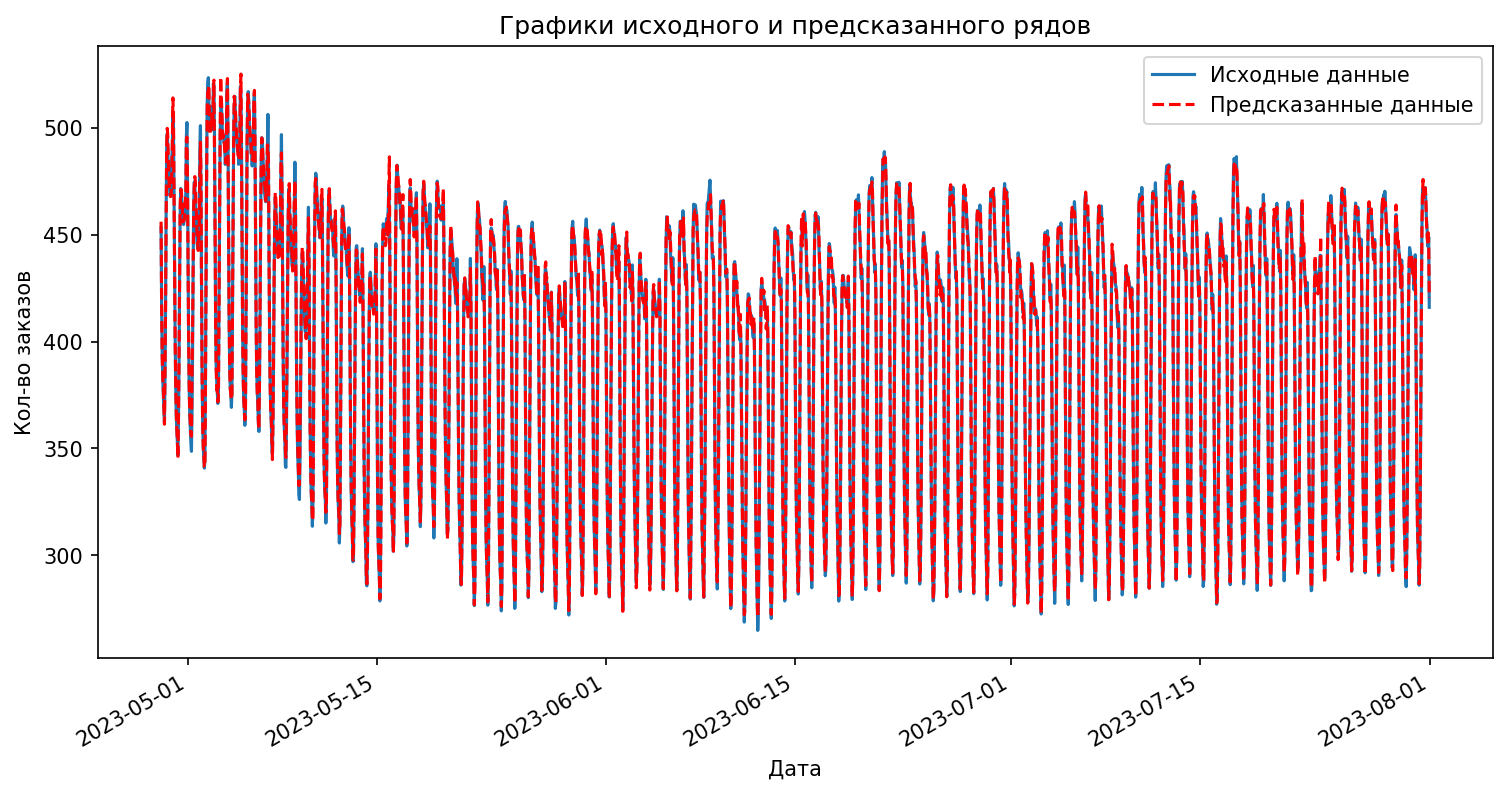

In [65]:
# Визуализируем графики исходного и предсказанного рядов
plt.figure(figsize=(12,6), dpi=150)
target_test.plot(label='1')
predictions[0].plot(label='2',style='r--')
plt.title('Графики исходного и предсказанного рядов')
plt.ylabel('Кол-во заказов')
plt.xlabel('Дата')
plt.legend(('Исходные данные', 'Предсказанные данные'))
plt.show()